In [1]:
import matplotlib.pyplot as plt

import numpy as np 
import scipy
from scipy.special import roots_legendre, factorial
from functools import partial

from einops import repeat

In [2]:
def ReLU(x, n):
    # ReLU activation function
    # n : degree 
    return np.maximum(0,x) ** n 

def dReLU(x,n,m):
    # derivatives of ReLU 
    # n : degree 
    # m : derivative order
    return factorial(n)/factorial(n-m) * np.maximum(0,x) ** (n-m) * (x>0)**m

In [17]:
class EllipticOGA1d:
    def __init__(self, nNeuron, nqpts):
        self.nNeuron = nNeuron 
        self.nqpts = nqpts 

        # quad points
        xqd, wei = roots_legendre(nqpts)
        self.xqd = xqd
        self.wei = wei

        # rhs
        self.K = 1.0
        self.f = self.rhs()

        # sol
        self.uk = np.zeros_like(self.f)
        self.duk = np.zeros_like(self.f)
        self.uref = np.cos(np.pi * self.xqd)
        self.duref = -np.pi * np.sin(np.pi * self.xqd)
        self.U = np.zeros((nNeuron, nqpts))

        # neural network
        self.act = partial(ReLU, n=2)
        self.dact = partial(dReLU, n=2, m=1)
        self.d2act = partial(dReLU, n=2, m=2)
        self.W = np.zeros((nNeuron, 1))
        self.Bias = np.zeros((nNeuron, 1))

        # wb search
        # gd, gradient descent method, 
        # fdeu, finite difference Newton's method with explicit Euler scheme,
        # fdcd, finite difference Newton's method with central difference scheme.

        self.nw = 2 
        self.nb = 4001
        self.gdn = 100

        # alpha search 
        self.C = np.zeros((nNeuron, nqpts))
        self.G = np.zeros((nNeuron, nqpts))
        self.Gd = np.zeros((nNeuron, nqpts))
        self.A = np.zeros((nNeuron,1))

        # current neuron
        self.k = 0

    def rhs(self):
        return (np.pi)**2 * np.cos(np.pi * self.xqd) + self.K*np.cos(np.pi * self.xqd)
    
    def error_display(self):
        errl2 = np.sum((self.uk - self.uref) ** 2 * self.wei)**0.5
        errh1 = np.sum(((self.duk - self.duref) ** 2 + (self.uk - self.uref) ** 2)* self.wei)**0.5
        print("{:}-th Neuron - L2 {:.5e} - H1 {:.5e}".format(self.k, errl2, errh1))


    def optimize(self):
        wk, bk = self.optimize_wb()
        self.W[self.k] = wk 
        self.Bias[self.k] = bk
        ak = self.optimize_alpha()
        self.A[:self.k+1] = ak.reshape(-1,1)

        self.uforward()
        self.duforward()

        # if self.k in [2, 4, 8, 16, 32, 64, 128]:
        if self.k % 10 == 0:
            self.error_display()
        self.U[self.k] = self.uk
        self.k += 1

    def uforward(self):
        self.uk = np.dot(self.act(self.W * self.xqd + self.Bias).T, self.A).reshape(-1)

    def duforward(self):
        self.duk = np.dot((self.dact(self.W * self.xqd + self.Bias) * self.W).T, self.A).reshape(-1)

    def initialguess_wb(self):
        W = np.linspace(-1,1, self.nw)
        B = np.linspace(-2,2, self.nb)
        ww, bb = np.meshgrid(W, B)
        ws, bs = ww.reshape(-1), bb.reshape(-1)

        loss = []
        for w, b in zip(ws, bs):
            c = w*self.xqd + b
            g = self.act(c)
            dg = self.dact(c)

            fg = self.f*g 
            ug = g*self.uk

            dudg = dg*self.duk*w

            rg = np.sum((dudg + self.K*ug - fg)*self.wei)
            E = -0.5 * rg**2
            loss.append(E)

        idx = np.argmin(loss)
        wi, bi = ws[idx], bs[idx]
        return wi, bi

    def gradientdescent_wb(self,w,b):
        dE = np.zeros(2)
        c    = w*self.xqd+b
        g    = self.act(c)
        dbg  = self.dact(c)
        dg   = dbg*w 
        dbdg = self.d2act(c)*w

        dudg = self.duk * dg 
        ug   = self.uk * g 
        fg   = self.f * g 

        rg = np.sum((dudg + self.K * ug - fg) * self.wei)
        E  = -0.5 * rg ** 2 

        rdbg = np.sum((self.duk*dbdg + self.K * self.uk * dbg - self.f * dbg) * self.wei)
        dE[1]   = -rg * rdbg
        return E, dE

    def optimize_wb(self):
        # initial guess by enumerate search
        wk, bk = self.initialguess_wb()
        E0, dE0 = self.gradientdescent_wb(wk,bk)
        
        # eta = 1e-12
        # for i in range(self.gdn):
        #     E, dE = self.gradientdescent_wb(wk, bk)
        #     bk = bk - eta * dE[1] # gd update
        #     E1, dE1 = self.gradientdescent_wb(wk, bk)
        #     if np.linalg.norm(dE1, ord=np.inf) > np.linalg.norm(dE, ord=np.inf):
        #         # print("early stop at : {:}".format(i))
        #         break
        
        return wk, bk
    
    def optimize_alpha(self):
        wk = self.W[self.k]
        bk = self.Bias[self.k]
        ck = wk * self.xqd + bk
        gk = self.act(ck)
        dgk = self.dact(ck)*wk

        self.C[self.k] = ck 
        self.G[self.k] = gk 
        self.Gd[self.k] = dgk 

        gs = self.G[:self.k+1]
        gds = self.Gd[:self.k+1]

        gg = np.dot(gs, (gs*self.wei).T)
        gdgd = np.dot(gds, (gds*self.wei).T)
        fg = np.sum(gs*self.f*self.wei, axis=1)

        ak = scipy.linalg.solve(self.K*gg+gdgd, fg)
        return ak
    
    def train(self):
        for _ in range(self.nNeuron):
            self.optimize()

In [18]:
model = EllipticOGA1d(128, 12000)

In [19]:
model.train()

2-th Neuron - L2 4.13591e-01 - H1 2.01171e+00
4-th Neuron - L2 7.12805e-02 - H1 5.42560e-01
8-th Neuron - L2 5.94909e-03 - H1 1.12075e-01
16-th Neuron - L2 6.05785e-04 - H1 2.25176e-02
32-th Neuron - L2 7.02913e-05 - H1 5.57984e-03
64-th Neuron - L2 7.95710e-06 - H1 1.33904e-03


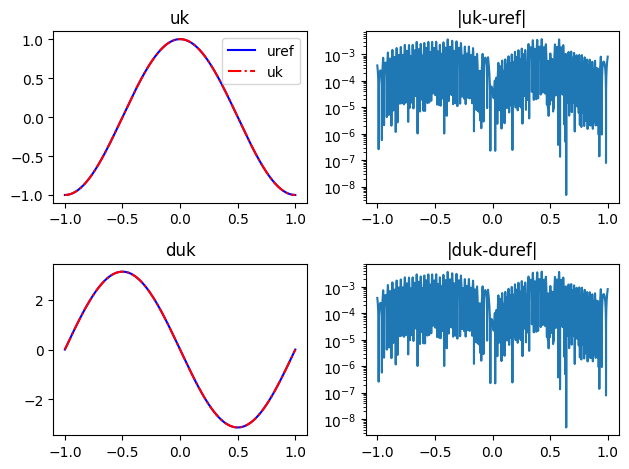

In [16]:
plt.subplot(221)
plt.plot(model.xqd, model.uref, '-b', label='uref')
plt.plot(model.xqd, model.uk, '-.r', label='uk')
plt.legend()
plt.title('uk')
plt.subplot(222)
plt.plot(model.xqd, np.abs(model.duk-model.duref))
plt.yscale('log')
plt.title('|uk-uref|')
plt.subplot(223)
plt.plot(model.xqd, model.duref, '-b', label='duref')
plt.plot(model.xqd, model.duk, '-.r', label='duk')
plt.title('duk')
plt.subplot(224)
plt.plot(model.xqd, np.abs(model.duk-model.duref))
plt.yscale('log')
plt.title('|duk-duref|')
plt.tight_layout()